<a href="https://colab.research.google.com/github/makezazainw/newresultsproject/blob/main/Original_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **ติดตั้ง Kaggle เเละ เรียกใช้ไฟล์ json เพื่อติดต่อใช้ dataset ใน kaggle**

In [1]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 5.3MB 12.2MB/s 
     |████████████████████████████████| 133kB 44.0MB/s 
     |████████████████████████████████| 112kB 34.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 


In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "thammatattantipitham" 
os.environ['KAGGLE_KEY'] = "3cf826ab97707228fb1602519992740b"

In [3]:
!kaggle datasets download -d thammatattantipitham/thaiherb --unzip

 79% 29.0M/36.8M [00:01<00:00, 11.9MB/s]
100% 36.8M/36.8M [00:01<00:00, 25.4MB/s]


In [4]:
#สร้างไฟล์ folder ขึ้นมาเเละเพิ่มข้อมูลเข้าไปใน folder
!mkdir thaiherb
!mv  "train" "val" thaiherb

### **เริ่มต้นการ import library ต่างๆเเละการเรียกใช้ไฟล์**


In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import keras

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.applications import InceptionV3
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [6]:
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [7]:
DATASET_PATH  = 'thaiherb/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 10
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
epochs    = 50

In [8]:
#ทำ aug มาเเล้ว
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
#set training data
train_generator = train_datagen.flow_from_directory(DATASET_PATH+ r"train/",
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset='training')

Found 825 images belonging to 10 classes.


In [10]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH+ r"val/",                                      
                                                    target_size = IMAGE_SIZE,
                                                    batch_size = 1,
                                                    class_mode='categorical',
                                                    shuffle = True
                                                    )

Found 359 images belonging to 10 classes.


### **Model ResNet50**

In [11]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_ResNet50/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
FREEZE_LAYERS = 2
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=10)

#Create the model
base_model_resnet = ResNet50(include_top=False,weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = base_model_resnet.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=output_layer)
for layer in model_resnet.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model_resnet.layers[FREEZE_LAYERS:]:
    layer.trainable = True
#Defining and Adding layers
model_resnet= Sequential()
#Add the Dense layers along with activation and batch normalization
model_resnet.add(base_model_resnet)
model_resnet.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_resnet.add(Dense(1024,activation=('relu'),input_dim=64))
model_resnet.add(Dense(512,activation=('relu'))) 
model_resnet.add(Dropout(.4))
model_resnet.add(Dense(256,activation=('relu'))) 
model_resnet.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_resnet.add(Dense(128,activation=('relu')))
model_resnet.add(Dropout(.2))
model_resnet.add(Dense(NUM_CLASSES,activation=('softmax'))) #This is the classification layer

# Save the weights using the `checkpoint_path` format
model_resnet.save_weights(checkpoint_path.format(epoch=0))

94773248/94765736 [==============================] - 4s 0us/step


In [12]:
#Model summary
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [13]:
model_resnet.compile(optimizer=Adam(lr=0.0001),  #Adam(lr=1e-5)
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#start to train the model
start = time.time()
history = model_resnet.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.samples/train_generator.batch_size, validation_data=valid_generator,validation_steps=valid_generator.samples/valid_generator.batch_size,callbacks=[cp_callback],verbose=1)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
26/25 [==============================] - 11s 435ms/step - loss: 1.9597 - accuracy: 0.3927 - val_loss: 0.8358 - val_accuracy: 0.7382
Epoch 2/50
26/25 [==============================] - 9s 364ms/step - loss: 0.7063 - accuracy: 0.7806 - val_loss: 0.2549 - val_accuracy: 0.9081
Epoch 3/50
26/25 [==============================] - 10s 365ms/step - loss: 0.2977 - accuracy: 0.8982 - val_loss: 0.1199 - val_accuracy: 0.9638
Epoch 4/50
26/25 [==============================] - 10s 365ms/step - loss: 0.1229 - accuracy: 0.9612 - val_loss: 0.1588 - val_accuracy: 0.9582
Epoch 5/50
26/25 [==============================] - 9s 365ms/step - loss: 0.0842 - accuracy: 0.9721 - val_loss: 0.0615 - val_accuracy: 0.9833
Epoch 6/50
26/25 [==============================] - 10s 366ms/step - loss: 0.0588 - accuracy: 0.9794 - val_loss: 0.0403 - val_accuracy: 0.9889
Epoch 7/50
26/25 [==============================] - 10s 367ms/step -

###**ขั้นตอนการ Save file Model เเละ Json**

In [ ]:
#เปลี่ยนชื่อไฟล์ทุกครั้งเวลา SAVE 
model_resnet.save('/content/drive/My Drive/Final Project/Dataset-Nature/Original/saved_model/model-resnet50(lastest).h5')
model_resnet.save_weights('/content/drive/My Drive/Final Project/Dataset-Nature/Original/saved_model/weightmodel-resnet50(lastest).h5')

In [ ]:
#Import dependencies
!mkdir jsonfile
import json
from keras.models import model_from_json, load_model
with open('jsonfile/model_resnet.json', 'w') as f:
    f.write(model_resnet.to_json())
print("Saved model success")

###**เเสดงกราฟข้อมูลค่าความเเม่นยำเเละค่าความสูญเสีย Training เเละ Validation**

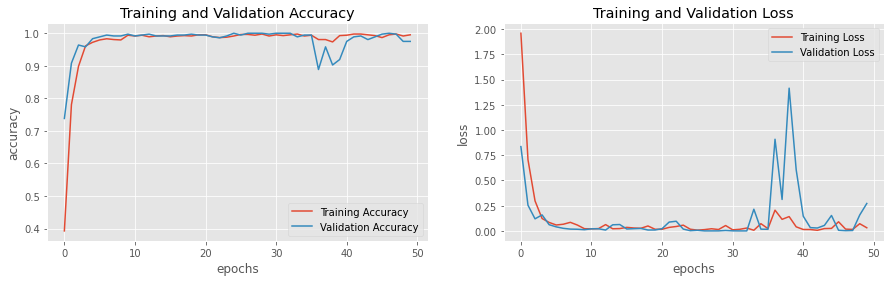

In [15]:
import matplotlib.pyplot as plt

acc = model_resnet.history.history['accuracy']
val_acc = model_resnet.history.history['val_accuracy']

loss= model_resnet.history.history['loss']
val_loss= model_resnet.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

###**จุด Checkpoint**

In [16]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_ResNet50/cp-0050.ckpt'

In [19]:
# Load the previously saved weights
model_resnet.load_weights(latest)

# Re-evaluate the model
loss, acc = model_resnet.evaluate(valid_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

359/359 - 5s - loss: 0.2720 - accuracy: 0.9749
Restored model, accuracy: 97.49%


###**Save model อีกเเบบเพื่อนำไปเเปลงเป็น TensorflwLite**

In [17]:
# Save the entire model as a SavedModel.
model_resnet.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
model= tf.keras.models.load_model('saved_model/my_model')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model(200epochsresnet).tflite", "wb").write(tflite_model) 

###**ขั้นตอนของ Prediction เเบบบ Confusion Matrix**

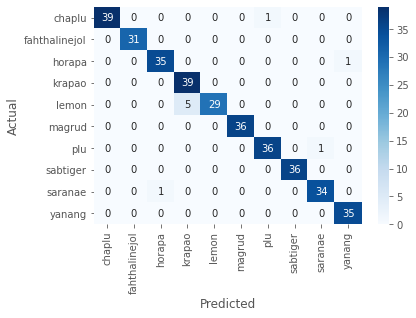

test accuracy : 97.49303621169916


In [18]:
import seaborn as sn
import pandas as pd

model = tf.keras.models.load_model('saved_model/my_model')
filenames = valid_generator.filenames
nb_samples = len(valid_generator)
y_prob=[]
y_act=[]
valid_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = valid_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)


predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot= True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))